In [86]:
from main import get_band_reflectance, load_panel_properties
from utils.debug import show_intensities

from utils.orthophoto import *

In [67]:
panel_properties_file = "../reflectance_panel_example_data.json"
geopackage_file = "../data/20240529_uav_multispectral_orthos_20m/20240529_tarps_locations.gpkg"
orthophotos_dir = "../data/20240529_uav_multispectral_orthos_20m/orthophotos"

In [68]:

panels = load_panel_properties(panel_properties_file)
panel_locations = load_panel_locations(geopackage_file)
orthophoto_paths = list(sorted(get_orthophoto_paths(orthophotos_dir)))
with rasterio.open(orthophoto_paths[0]) as orthophoto:
    number_of_bands = len(orthophoto.read())

assert len(panels) == len(panel_locations)
assert number_of_bands == len(panels[0]['bands'])

# 1. For each image extract each panel intensities for each band

In [69]:
intensities = np.zeros((len(orthophoto_paths), len(panel_locations), number_of_bands))
intensities.shape

(296, 3, 6)

100%|██████████| 296/296 [00:30<00:00,  9.75it/s]


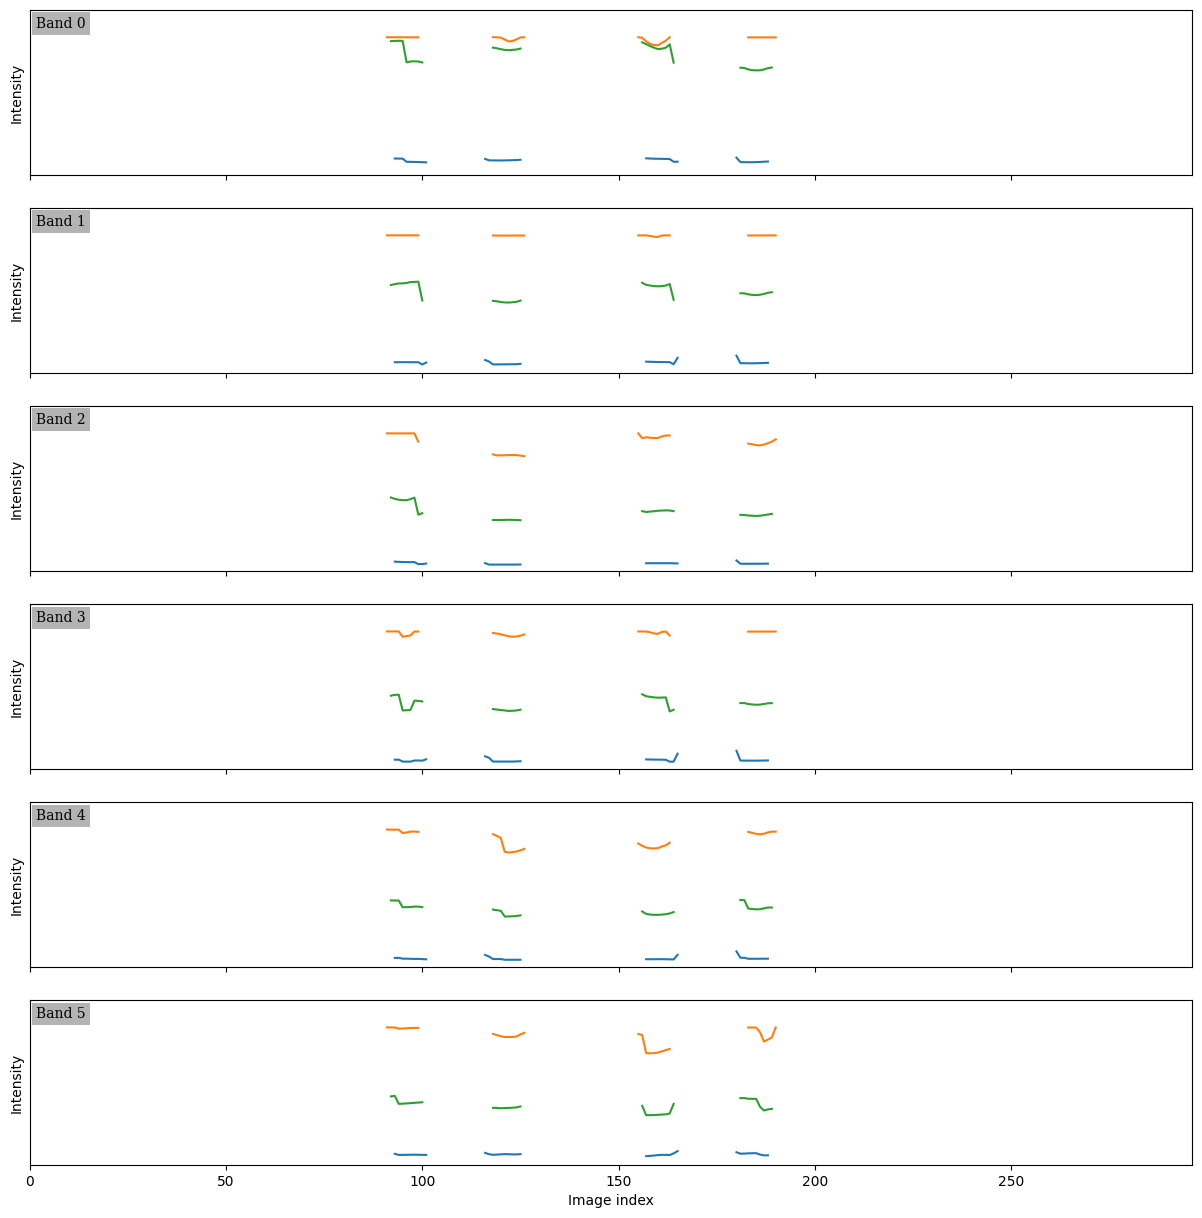

In [88]:
# Extract intensities
for photo_index, orthophoto_path in enumerate(tqdm(orthophoto_paths)):
    with rasterio.open(orthophoto_path) as orthophoto:
        photo = orthophoto.read()
        for panel_index, panel in enumerate(panel_locations):
            if not is_panel_in_orthophoto(orthophoto_path, panel):
                intensities[photo_index][panel_index] = np.full(len(photo), np.NaN)
                continue
            panel_intensities_per_band = extract_using_geolocation(orthophoto, panel)
            intensities[photo_index][panel_index] = panel_intensities_per_band
show_intensities(intensities)

# Interpolate the intensities by panel and band

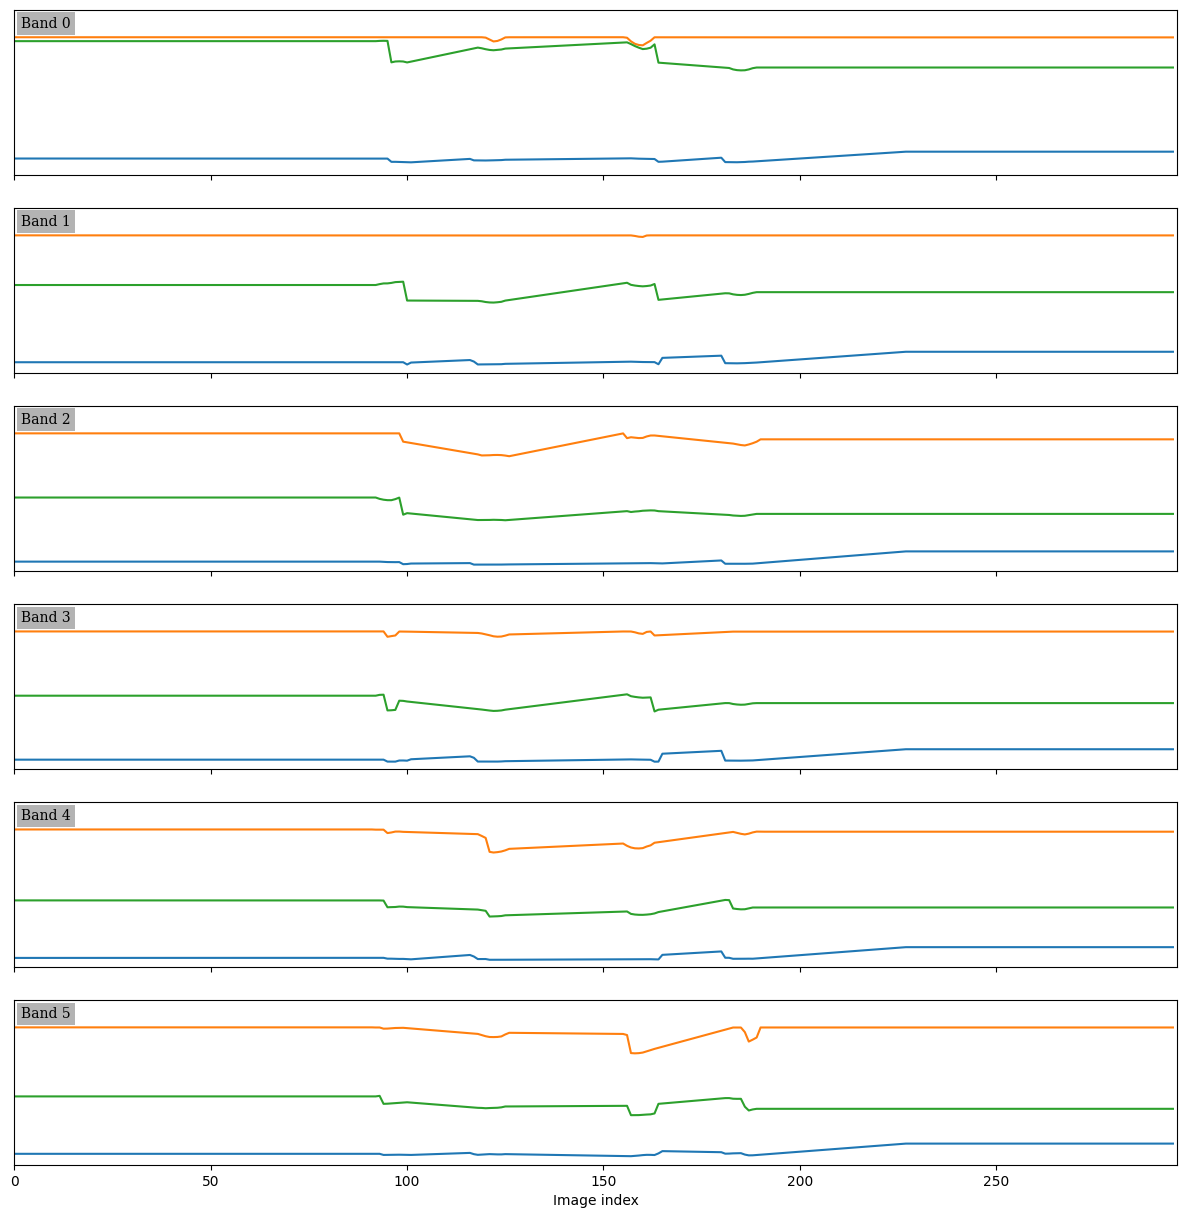

In [81]:
for panel_index, panel in enumerate(panel_locations):
    for band_index in range(0, number_of_bands):
        intensities[:, panel_index, band_index] = interpolate(intensities[:, panel_index, band_index])
show_intensities(intensities)

# Convert photos by photo and band

In [32]:
unconvertable_photos = []
converted_photos = []
for photo_index, orthophoto_path in enumerate(tqdm(orthophoto_paths)):
    converted_bands = []
    with rasterio.open(orthophoto_path) as orthophoto:
        photo = orthophoto.read()
    for band_index, band in enumerate(photo):
        intensities_of_panels = intensities[photo_index, :, band_index]
        if np.isnan(intensities_of_panels).any():
            unconvertable_photos.append((photo_index, band_index))
            converted_photos.append(None)
            break
        coeffs = fit(intensities_of_panels, get_band_reflectance(panels, band_index))
        converted_bands.append(convert(band, coeffs))
    else:
        # for loop did not break, all bands were converted
        converted_photos.append(converted_bands)

100%|██████████| 296/296 [00:24<00:00, 12.10it/s]


In [57]:
save_orthophotos(orthophoto_paths, converted_photos)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 1711, 'height': 1604, 'count': 6, 'crs': CRS.from_epsg(4326), 'transform': Affine(1.8322500000007721e-07, 0.0, 9.917434452175,
       0.0, -1.1419499999862837e-07, 51.56494755632)}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1711, 'height': 1604, 'count': 6, 'crs': CRS.from_epsg(4326), 'transform': Affine(1.8322500000007721e-07, 0.0, 9.917434452175,
       0.0, -1.1419499999862837e-07, 51.56494755632)}
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 1673, 'height': 1538, 'count': 6, 'crs': CRS.from_epsg(4326), 'transform': Affine(1.8322500000028447e-07, 0.0, 9.917406968424999,
       0.0, -1.141950000025455e-07, 51.564897196325)}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1673, 'height': 1538, 'count': 6, 'crs': CRS.from_epsg(4326), 'transform': Affine(1.8322500000028447e-07, 0.0, 9.917406968424999,
       0.0, -1.141950000025455e-07, 51.564897196325)}
{'driver': '

KeyboardInterrupt: 